In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset
dataset = load_dataset("openfoodfacts/product-database")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

food.parquet:   0%|          | 0.00/5.76G [00:00<?, ?B/s]

beauty.parquet:   0%|          | 0.00/36.3M [00:00<?, ?B/s]

Generating food split: 0 examples [00:00, ? examples/s]

Generating beauty split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/58 [00:00<?, ?it/s]

DatasetDict({
    food: Dataset({
        features: ['additives_n', 'additives_tags', 'allergens_tags', 'brands_tags', 'brands', 'categories', 'categories_tags', 'checkers_tags', 'ciqual_food_name_tags', 'cities_tags', 'code', 'compared_to_category', 'complete', 'completeness', 'correctors_tags', 'countries_tags', 'created_t', 'creator', 'data_quality_errors_tags', 'data_quality_info_tags', 'data_quality_warnings_tags', 'data_sources_tags', 'ecoscore_data', 'ecoscore_grade', 'ecoscore_score', 'ecoscore_tags', 'editors', 'emb_codes_tags', 'emb_codes', 'entry_dates_tags', 'food_groups_tags', 'generic_name', 'images', 'informers_tags', 'ingredients_analysis_tags', 'ingredients_from_palm_oil_n', 'ingredients_n', 'ingredients_original_tags', 'ingredients_percent_analysis', 'ingredients_tags', 'ingredients_text', 'ingredients_with_specified_percent_n', 'ingredients_with_unspecified_percent_n', 'ingredients_without_ciqual_codes_n', 'ingredients_without_ciqual_codes', 'ingredients', 'known_ing

In [3]:
food_data = dataset['food']

In [4]:
!pip install datasets duckdb

In [5]:
arrow_table = food_data.data.table

In [6]:
import duckdb
con = duckdb.connect()

In [7]:
con.register('food_table', arrow_table)

In [8]:
schema_df = con.execute("""DESCRIBE food_table""").fetchdf()
print(schema_df)

                       column_name column_type null   key default extra
0                      additives_n     INTEGER  YES  None    None  None
1                   additives_tags   VARCHAR[]  YES  None    None  None
2                   allergens_tags   VARCHAR[]  YES  None    None  None
3                      brands_tags   VARCHAR[]  YES  None    None  None
4                           brands     VARCHAR  YES  None    None  None
..                             ...         ...  ...   ...     ...   ...
104          unknown_ingredients_n     INTEGER  YES  None    None  None
105         unknown_nutrients_tags   VARCHAR[]  YES  None    None  None
106                  vitamins_tags   VARCHAR[]  YES  None    None  None
107  with_non_nutritive_sweeteners     INTEGER  YES  None    None  None
108                with_sweeteners     INTEGER  YES  None    None  None

[109 rows x 6 columns]


In [9]:
total_rows = con.execute("SELECT COUNT(*) AS total_rows FROM food_table").fetchone()[0]
print(total_rows)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3603397


In [10]:
nutritional_fields = ['energy_100g', 'proteins_100g', 'sugars_100g', 'fat_100g']

nutritional_field_extractions = [
    f"COUNT(CASE WHEN JSON_EXTRACT(nutriments, '$.{col}') IS NULL THEN 1 END) AS {col}_missing"
    for col in nutritional_fields
]

missing_nutrition_df = con.execute(
    f"""
    SELECT
        COUNT(CASE WHEN images IS NULL THEN 1 END) AS images_missing,
        {', '.join(nutritional_field_extractions)}
    FROM food_table
    """
).fetchdf()

print(missing_nutrition_df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   images_missing  energy_100g_missing  proteins_100g_missing  \
0               0              3603397                3603397   

   sugars_100g_missing  fat_100g_missing  
0              3603397           3603397  


In [11]:
con.execute("""
    CREATE TABLE parsed_food_table AS
    SELECT
        code,
        product_name,
        categories_tags,
        images,
        JSON_EXTRACT(nutriments, '$.energy_100g')::DOUBLE AS energy_100g,
        JSON_EXTRACT(nutriments, '$.proteins_100g')::DOUBLE AS proteins_100g,
        JSON_EXTRACT(nutriments, '$.sugars_100g')::DOUBLE AS sugars_100g,
        JSON_EXTRACT(nutriments, '$.fat_100g')::DOUBLE AS fat_100g
    FROM food_table
    WHERE images IS NOT NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
ml_data_query = """
SELECT
    code,
    product_name,
    energy_100g,
    proteins_100g,
    sugars_100g,
    fat_100g,
    categories_tags,
    images
FROM parsed_food_table
LIMIT 10000
"""
ml_data = con.execute(ml_data_query).fetchdf()
print(ml_data.head())

            code                                       product_name  \
0  0000101209159  [{'lang': 'main', 'text': 'Véritable pâte à ta...   
1  0000105000011  [{'lang': 'main', 'text': 'Lagg's, chamomile h...   
2  0000105000042  [{'lang': 'main', 'text': 'Lagg's, herbal tea,...   
3  0000105000059  [{'lang': 'main', 'text': 'Linden Flowers Tea'...   
4  0000105000073  [{'lang': 'main', 'text': 'Herbal Tea, Hibiscu...   

   energy_100g  proteins_100g  sugars_100g  fat_100g  \
0          NaN            NaN          NaN       NaN   
1          NaN            NaN          NaN       NaN   
2          NaN            NaN          NaN       NaN   
3          NaN            NaN          NaN       NaN   
4          NaN            NaN          NaN       NaN   

                                     categories_tags  \
0  [en:breakfasts, en:spreads, en:sweet-spreads, ...   
1  [en:plant-based-foods-and-beverages, en:bevera...   
2  [en:plant-based-foods-and-beverages, en:bevera...   
3           

In [13]:
completeness_stats = ml_data.notna().mean() * 100
print(completeness_stats)

code               100.00
product_name       100.00
energy_100g          0.00
proteins_100g        0.00
sugars_100g          0.00
fat_100g             0.00
categories_tags     88.86
images             100.00
dtype: float64


In [ ]:
completeness_stats = ml_data.notna().mean() * 100
completeness_stats.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='purple', edgecolor='black')
plt.title("Column Completeness (%)")
plt.xlabel("Columns")
plt.ylabel("Completeness (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

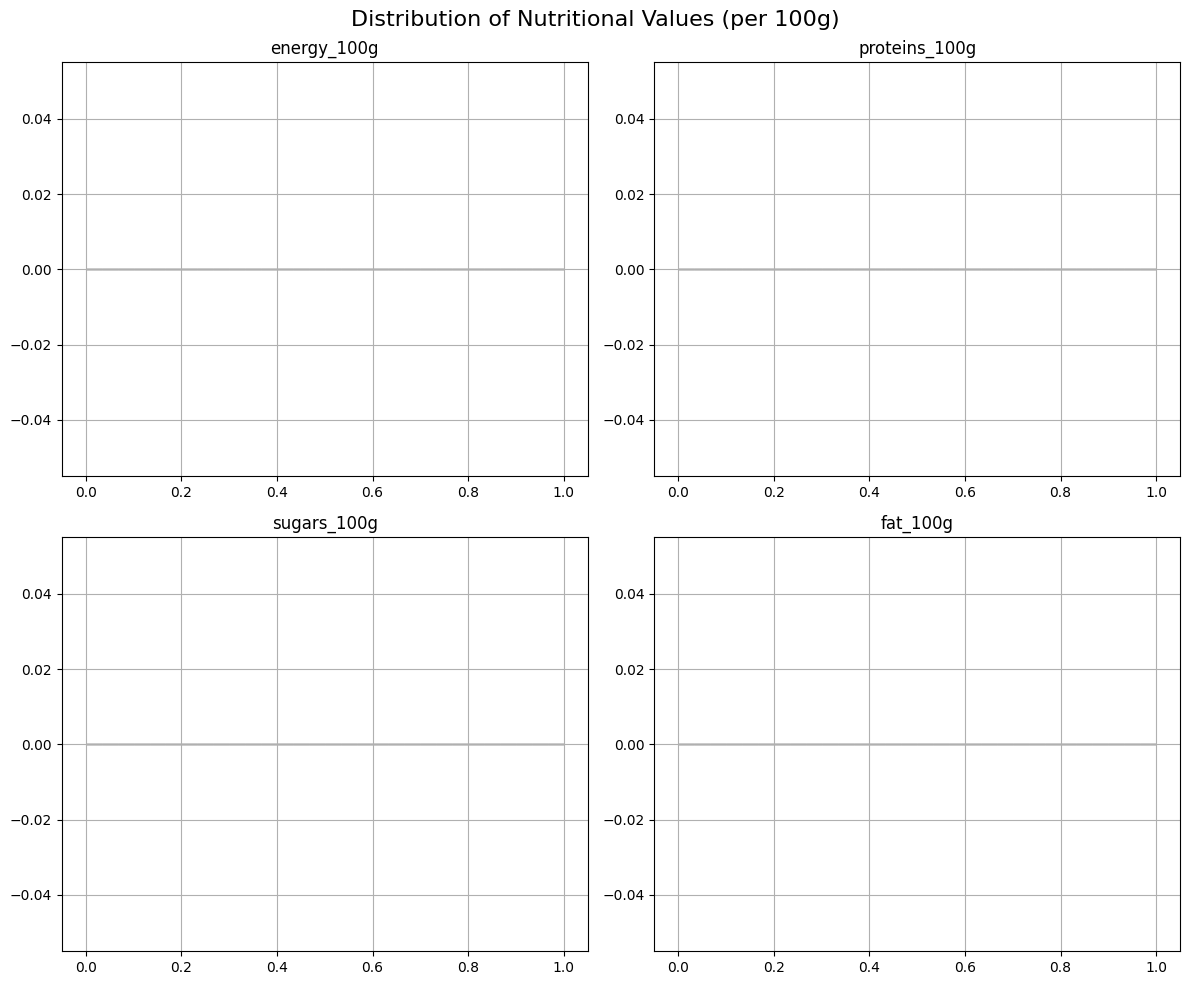

In [14]:
import matplotlib.pyplot as plt

nutritional_columns = ['energy_100g', 'proteins_100g', 'sugars_100g', 'fat_100g']

ml_data[nutritional_columns].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of Nutritional Values (per 100g)", fontsize=16)
plt.tight_layout()
plt.show()


Top 10 Categories:
categories_tags
[en:snacks]                645
[en:salted-snacks]         279
[en:baking-decorations]    104
[en:frozen-foods]          102
[en:fats]                   51
[en:desserts]               48
[en:meals]                  40
[en:beverages]              34
[en:cooking-helpers]        34
[en:sandwiches]             20
Name: count, dtype: int64


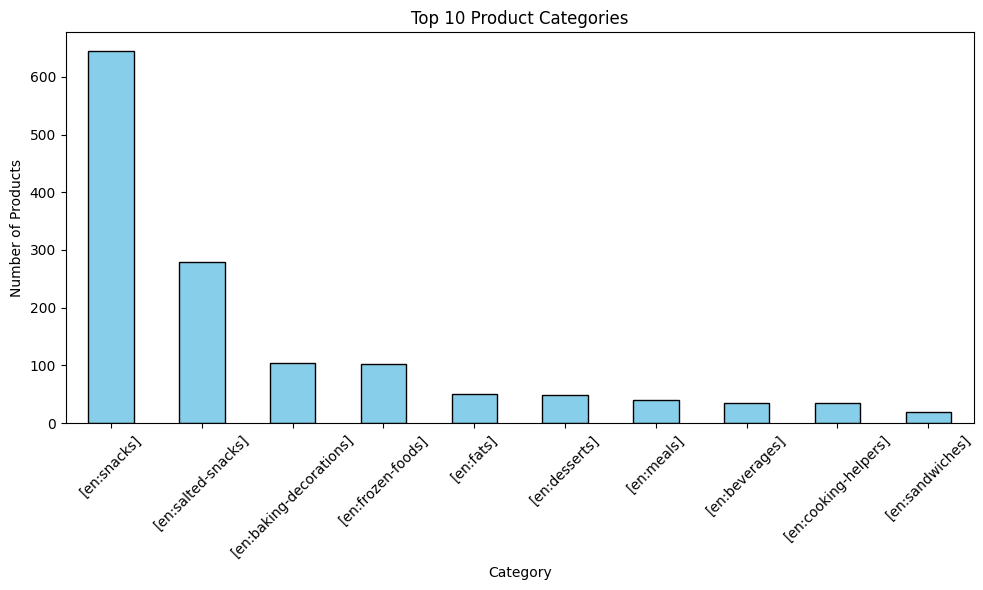

In [15]:
top_categories = ml_data['categories_tags'].value_counts().head(10)
print("\nTop 10 Categories:")
print(top_categories)

top_categories.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title("Top 10 Product Categories")
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
image_availability = ml_data['images'].notna().mean() * 100
print(image_availability)

100.0


In [19]:
!pip install wordcloud

In [ ]:
# from wordcloud import WordCloud

# categories_text = " ".join(str(cat) for cat in ml_data['categories_tags'].dropna())
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(categories_text)

# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Word Cloud of Categories")
# plt.show()

In [ ]:
# product_names_text = " ".join(str(name) for name in ml_data['product_name'].dropna())
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_names_text)

# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Product Names")
# plt.show()

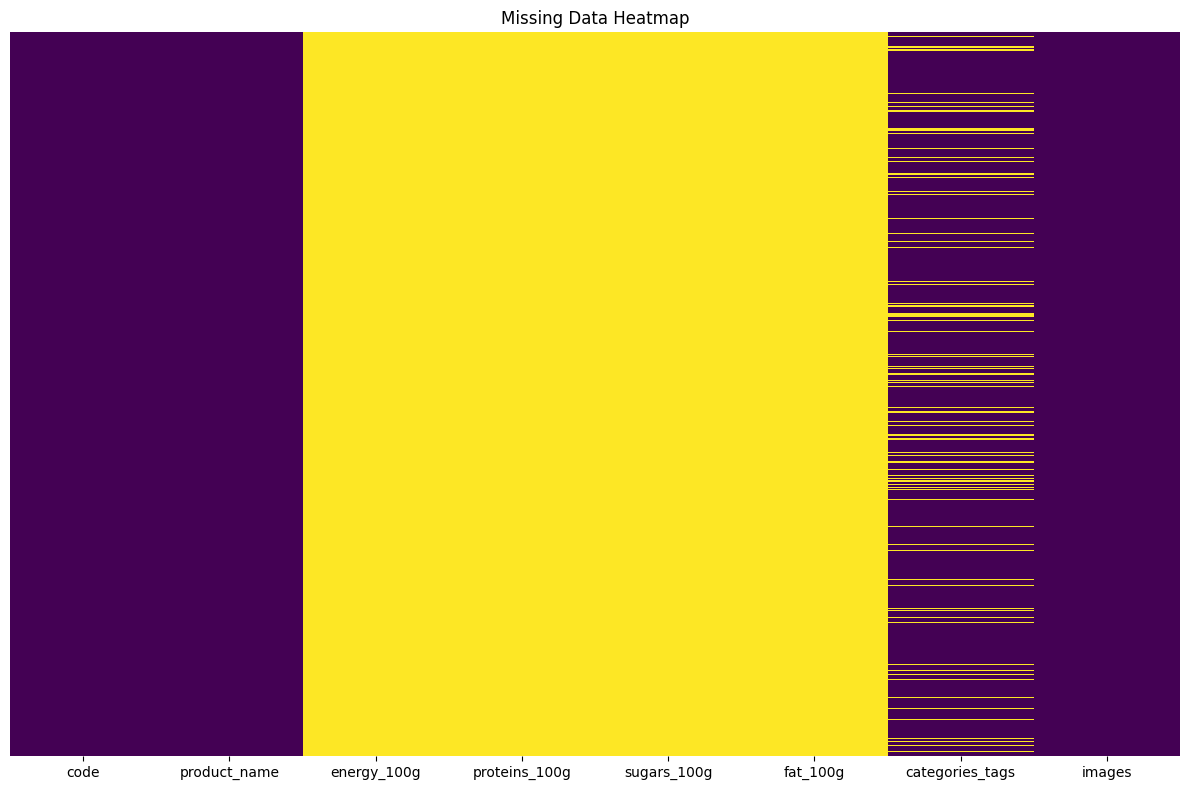

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(ml_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Heatmap")
plt.tight_layout()
plt.show()

In [32]:
print("First 5 entries in 'categories_tags':")
print(ml_data['categories_tags'].head())
ml_data['num_categories'] = ml_data['categories_tags'].apply(lambda x: len(x) if isinstance(x, np.ndarray) else 0)
print("Categories per Product:")
print(ml_data['num_categories'].value_counts())


First 5 entries in 'categories_tags':
0    [en:breakfasts, en:spreads, en:sweet-spreads, ...
1    [en:plant-based-foods-and-beverages, en:bevera...
2    [en:plant-based-foods-and-beverages, en:bevera...
3                                                  NaN
4                                                  NaN
Name: categories_tags, dtype: object
Categories per Product:
num_categories
4     1791
3     1624
1     1416
0     1258
7      945
5      849
2      587
6      470
8      314
9      290
10     156
11     101
12      84
13      80
15      14
14      14
16       4
19       3
Name: count, dtype: int64


In [33]:
def extract_first_category(x):
    if isinstance(x, np.ndarray):
        if x.size > 0:
            return x[0]
        else:
            return 'Unknown'
    elif pd.notna(x):
        return str(x)
    else:
        return 'Unknown'

ml_data['category'] = ml_data['categories_tags'].apply(extract_first_category)

print("\nFirst 5 entries after extracting 'category':")
print(ml_data[['categories_tags', 'category']].head())


First 5 entries after extracting 'category':
                                     categories_tags  \
0  [en:breakfasts, en:spreads, en:sweet-spreads, ...   
1  [en:plant-based-foods-and-beverages, en:bevera...   
2  [en:plant-based-foods-and-beverages, en:bevera...   
3                                                NaN   
4                                                NaN   

                             category  
0                       en:breakfasts  
1  en:plant-based-foods-and-beverages  
2  en:plant-based-foods-and-beverages  
3                             Unknown  
4                             Unknown  


In [34]:
category_counts = ml_data['category'].value_counts()
print("\nCategory Counts:")
print(category_counts.head(10))


Category Counts:
category
en:plant-based-foods-and-beverages    2558
en:snacks                             2154
Unknown                               1258
en:condiments                          885
en:dairies                             701
en:beverages                           359
en:desserts                            356
en:meats-and-their-products            337
en:meals                               290
en:salted-snacks                       279
Name: count, dtype: int64


In [35]:
if 'category' in ml_data.columns and 'images' in ml_data.columns:
    category_image_availability = ml_data.groupby('category')['images'].apply(lambda x: x.notna().mean() * 100)
    print(category_image_availability.head(10))

category
Unknown                                    100.0
en:baking-decorations                      100.0
en:bearnaise-sauce-mix                     100.0
en:beverages                               100.0
en:beverages-and-beverages-preparations    100.0
en:boissons                                100.0
en:breakfasts                              100.0
en:broths                                  100.0
en:canned-foods                            100.0
en:carrot-coriander-soup                   100.0
Name: images, dtype: float64
